### Representation learning for boxing

In [8]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

select_device(0)

class torch_reshape(torch.nn.Module):
    def forward(self, x, size=[64,7,7]):
        batch_size = x.shape[0]
        return x.view(batch_size, size[0], size[1], size[2])

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class SRNetImageParallel(nn.Module):
    def __init__(self, output_dim, hidden_units_sr=(512*4,), hidden_units_psi2q=(), gate=F.relu, config=1):
        """
        This network has two heads: SR head (SR) and reconstruction head (rec).
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetImageParallel, self).__init__()
        self.feature_dim = 512
        self.output_dim = output_dim
        self.gate = gate
        in_channels = 4
        
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)),  # b, 16, 10, 10
            nn.ReLU(True),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)), 
            nn.ReLU(True),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)), 
            nn.ReLU(True),
            Flatten()
        )
        
        self.conv2phi = nn.Linear(7 * 7 * 64, self.feature_dim)
        
        self.decoder = nn.Sequential(
            layer_init(nn.Linear(self.feature_dim, 7 * 7 * 64)),
            torch_reshape(),
            layer_init(nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)),  # b, 16, 5, 5
            nn.ReLU(True),
            layer_init(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)),  # b, 16, 5, 5
            nn.ReLU(True),
            layer_init(nn.ConvTranspose2d(32, in_channels, kernel_size=8, stride=4, output_padding=0)),
            nn.ReLU(True),
            nn.Tanh()
        )

        # layers for SR
        dims_sr = (7 * 7 * 64,) + hidden_units_sr + (self.feature_dim * output_dim,)
        self.conv2psi = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims_sr[:-1], dims_sr[1:])])

        # SR final head layer
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, self.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, self.feature_dim, hidden_units=hidden_units_psi2q)

        self.to(Config.DEVICE)

    def forward(self, x):

        # Finding the latent layer
        flat = self.encoder(tensor(x)) # shape: b x state_dim
        phi = self.conv2phi(flat)
        state_est = self.decoder(phi)
        
        # Estimating the SR from the latent layer
        psi = flat
        for layer in self.conv2psi[:-1]:
            psi = self.gate(layer(psi))
        psi = self.conv2psi[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.feature_dim) # shape: b x action_dim x state_dim

        q_est = self.psi2q(psi)

        return phi, psi, state_est, q_est

class avDSRAgent_v2(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_rec_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.choice = config.choice
        self.actor = avDSRActor_v2(config, agents, style, self.choice)

        self.network = config.network_fn()
        self.network.share_memory()
        # self.optimizer = config.optimizer_fn(self.network.parameters())
        self.optimizer_phi = config.optimizer_fn(list(self.network.encoder.parameters()) + list(self.network.conv2phi.parameters()) + list(self.network.decoder.parameters()))
        self.optimizer_psi = config.optimizer_fn(list(self.network.encoder.parameters()) + list(self.network.conv2psi.parameters()))

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:

            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _, _ = self.network(next_states)

            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            phi, psi, state_rec, _ = self.network(states)
            psi_next.add_(phi) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            psi = psi[self.batch_indices, actions, :]
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            # Estimating reconstuction loss
            loss_rec = (state_rec - tensor(states)).pow(2).mul(0.5).mean()
            loss = loss_psi + config.c(self.total_steps) * loss_rec
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(loss_psi.item())
            self.loss_rec_vec.append(loss_rec.item())

            # for g in self.optimizer.param_groups:
            #     g['lr'] = config.lr_1(self.total_steps)
            
            # Alternative way to estiamte the loss
            # Step 1: Update weights of phi and phi_rec
            self.optimizer_phi.zero_grad()
            loss_rec.backward(retain_graph=True)
            with config.lock:
                self.optimizer_phi.step() 
            # Step 2: Update weights of psi
            self.optimizer_psi.zero_grad()
            loss_psi.backward()
            with config.lock:
                self.optimizer_psi.step()
                
def avdsr_feature_v2(dnn, **kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = LinearSchedule(1, 1, 5e3)
    # config.lr_1 = LinearSchedule(1e-3, 1e-3, 5e3)

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=5e-5)
    if(dnn is not None):
        config.network_fn = lambda: dnn
    else:
        config.network_fn = lambda: SRNetImageParallel(config.action_dim, config=1) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e4), batch_size=10)
    config.state_normalizer = ImageNormalizer()
    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent_v2(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    
class Pick():
    def __init__(self):
        self.network = 0
        
class avDSRActor_v2(BaseActor):
    def __init__(self, config, agents, style='DQN', choice=1):
        """
        style -> depicts the network config of the agent used for exploration.
        choice -> tells how we choose which agent to use for exploration
            0 - at every timestep, we randomly pick and agent and take an eps greedy action
            1 - we choose a new DQN every switch_period
        """
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style
        self.choice = choice

        # Parameters to decide which agents should learn
        self.batch_steps = 0
        self.switch_period = 10
        self.agent_id = 0

        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        
        # Choosing which agent for taking actions

        if(len(self.agents) == 0):
            pick = Pick()
            pick.network = lambda a: torch.zeros(self.config.action_dim,1)
        elif(self.choice == 0):                
            pick = random.choice(self.agents)
        elif(self.choice == 1):
            self.batch_steps += 1
            if(self.batch_steps % self.switch_period == 0): 
                # CHECK: multiprocessing might be screwing something up
                self.agent_id = np.random.randint(len(self.agents))
            pick = self.agents[self.agent_id]
        else:
            raise NameError('Invalid choice config')

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            elif(self.style == 'DQN'):
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps                 or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        if(len(self.agents) == 0):
            pick2 = Pick()
            pick2.network = lambda a : torch.zeros(self.config.action_dim,1)
        elif(self.choice == 0):
            pick2 = random.choice(self.agents)
        elif(self.choice == 1):
            pick2 = pick

        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            elif(self.style=='DQN'):
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps                 or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry

In [9]:
game='BoxingNoFrameskip-v0'
avdsr = avdsr_feature_v2(game=game, agents=[], choice=0, dnn=None)

2020-10-07 07:18:17,409 - root - INFO: steps 0, 116508444.44 steps/s
2020-10-07 07:18:22,023 - root - INFO: steps 1000, 216.81 steps/s
2020-10-07 07:18:26,652 - root - INFO: steps 2000, 216.17 steps/s
2020-10-07 07:18:31,227 - root - INFO: steps 3000, 218.67 steps/s
2020-10-07 07:18:35,748 - root - INFO: steps 4000, 221.29 steps/s
2020-10-07 07:18:40,216 - root - INFO: steps 5000, 223.90 steps/s
2020-10-07 07:18:44,707 - root - INFO: steps 6000, 222.76 steps/s
2020-10-07 07:18:49,269 - root - INFO: steps 7000, 219.33 steps/s
2020-10-07 07:18:53,797 - root - INFO: steps 8000, 220.94 steps/s
2020-10-07 07:18:58,321 - root - INFO: steps 9000, 221.14 steps/s
2020-10-07 07:19:02,859 - root - INFO: steps 10000, 220.44 steps/s
2020-10-07 07:19:07,398 - root - INFO: steps 11000, 220.42 steps/s
2020-10-07 07:19:11,959 - root - INFO: steps 12000, 219.35 steps/s
2020-10-07 07:19:16,487 - root - INFO: steps 13000, 220.93 steps/s
2020-10-07 07:19:20,943 - root - INFO: steps 14000, 224.51 steps/s
20

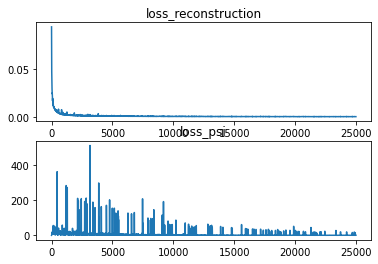

In [10]:
plt.subplot(211), plt.plot(convolve(avdsr.loss_rec_vec,10)[:]), plt.title('loss_reconstruction')
plt.subplot(212), plt.plot(convolve(avdsr.loss_psi_vec,10)[:]), plt.title('loss_psi')
plt.show()

In [12]:
avdsr.network.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'conv2phi.weight', 'conv2phi.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias', 'conv2psi.0.weight', 'conv2psi.0.bias', 'conv2psi.1.weight', 'conv2psi.1.bias', 'psi2q.layers.0.weight', 'psi2q.layers.0.bias'])

In [13]:
import gym
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from baselines.common.atari_wrappers import FrameStack as FrameStack_
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv
class TransposeImage(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(TransposeImage, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(FrameStack_):
    def __init__(self, env, k):
        FrameStack_.__init__(self, env, k)

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))
    
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self.__array__())

    def __getitem__(self, i):
        return self.__array__()[i]

In [14]:
env_id='BoxingNoFrameskip-v0'
env = make_atari(env_id)
env = wrap_deepmind(env, episode_life=True, clip_rewards=False, frame_stack=False, scale=False)
obs_shape = env.observation_space.shape
if len(obs_shape) == 3:
    env = TransposeImage(env)
env = FrameStack(env, 4)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


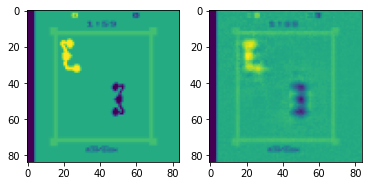

In [16]:
obs = env.reset()
obs = tensor(obs)/255.0
a, b, recons, _ = avdsr.network(obs.unsqueeze(0))
re_np = recons.squeeze(0).detach().cpu().numpy()
imgIn = tensor(obs).cpu().numpy()[0,:,:]
imgRe = re_np[0,:,:]

plt.subplot(121), plt.imshow(imgIn)
plt.subplot(122), plt.imshow(imgRe); plt.show()

In [29]:
# torch.save(avdsr.network, '../storage/41-avdsr-trained-boxing-512.weights')

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SRNetImage. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type torch_reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
